In [1]:
from keras.optimizers import SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')
import time
%matplotlib inline
from pprint import pprint

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
print("GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
print("TensorFlow Version: ", tf.__version__)
print("CUDA Version: ", tf.test.is_built_with_cuda())

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Version:  2.15.0
CUDA Version:  True


### VGG1 Model

In [5]:
def VGG1():
    model = Sequential()
    model.add(Input(shape=(200, 200, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(learning_rate=0.001, momentum=0.5)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### VGG2 Model

In [6]:
def VGG2():
    model = Sequential()
    model.add(Input(shape=(200, 200, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(learning_rate=0.005, momentum=0.5)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model



### VGG3 Model

In [7]:

def VGG3():
    model = Sequential()
    model.add(Input(shape=(200, 200, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(learning_rate=0.009, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### VGG16 Model

*With tuning all the layers*

In [69]:
def vgg16():
    model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
    for layer in model_vgg16.layers:
        layer.trainable = True
    x = Flatten()(model_vgg16.output)
    x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=model_vgg16.inputs, outputs=x)
    opt = SGD(learning_rate=0.005, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

*With tuning only the MLP layers*

In [70]:
def vgg16_MLP():
    model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
    for layer in model_vgg16.layers:
        layer.trainable = False
    x = Flatten()(model_vgg16.output)
    x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=model_vgg16.inputs, outputs=x)
    opt = SGD(learning_rate=0.005, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### MLP Model

*Having parameters comparable to the VGG16 model*

In [91]:
def MLP():
    model = Sequential()
    model.add(Input(shape=(200, 200, 3)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def train(model,train_dir, test_dir, name):
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=40, target_size=(200, 200))
    test_it = datagen.flow_from_directory(test_dir, class_mode='binary', batch_size=10, target_size=(200, 200))

    log_dir = f"runs/{name}_callback_dir"
    callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='batch')

    history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it),callbacks=[callback], epochs=20, verbose=2)
    return history

In [12]:
def train_augmentation(model,train_dir, test_dir,name):
    datagen = ImageDataGenerator(rescale=1.0/255.0, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    train_it = datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=40, target_size=(200, 200))
    test_it = datagen.flow_from_directory(test_dir, class_mode='binary', batch_size=10, target_size=(200, 200))
    train_steps_per_epoch = len(train_it)
    test_steps_per_epoch = len(test_it)
    log_dir = f"runs/{name}_callback_dir"
    callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='batch')
    history = model.fit(train_it, steps_per_epoch=train_steps_per_epoch, validation_data=test_it, validation_steps=test_steps_per_epoch,callbacks=[callback], epochs=20, verbose=2)
    return history

In [13]:
def test(model,test_dir):
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_it = datagen.flow_from_directory(test_dir, class_mode='binary', batch_size=10, target_size=(200, 200))
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=2)
    print(f'Accuracy: {acc*100}')
    return acc*100

In [14]:
def summarize_diagnostics(history,txt):
    plt.figure(figsize=(8,4))
    plt.title(txt + 'Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend(['train', 'test'], loc='upper right')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.tight_layout()
    plt.show()
    plt.savefig(txt + '_loss_plot.png')

    plt.figure(figsize=(8,4))
    plt.title(txt + 'Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend(['train', 'test'], loc='upper right')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.tight_layout()
    plt.show()
    plt.savefig(txt + '_accuracy_plot.png')

In [15]:
def parameters(model):
    print(model.summary())
    return model.count_params()

In [94]:
data = {
    'Model': [],
    'Total Parameters': [],
    'Training Time': [],
    'Test Time': [],
    'Training Loss': [],
    'Test Loss': [],
    'Training Accuracy': [],
    'Test Accuracy': []
}

#### *VGG1*

In [17]:
vgg1 = VGG1()
params_vgg1 = parameters(vgg1)
print(f"Total Parameters in VGG1: {params_vgg1}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 320000)            0         
                                                                 
 dense (Dense)               (None, 128)               40960128  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 40961153 (156.25 MB)
Trainable params: 40961153 (156.25 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [18]:
start_time = time.time()
history_vgg1 = train(vgg1,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test','vgg1')
end_time = time.time()
time_vgg1 = end_time - start_time
print(f'Time taken for VGG1: {time_vgg1}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/20
4/4 - 63s - loss: 1.5897 - accuracy: 0.5312 - val_loss: 0.6346 - val_accuracy: 0.7500 - 63s/epoch - 16s/step
Epoch 2/20
4/4 - 7s - loss: 0.6530 - accuracy: 0.6313 - val_loss: 0.6232 - val_accuracy: 0.5750 - 7s/epoch - 2s/step
Epoch 3/20
4/4 - 5s - loss: 0.6421 - accuracy: 0.6500 - val_loss: 0.5590 - val_accuracy: 0.7750 - 5s/epoch - 1s/step
Epoch 4/20
4/4 - 6s - loss: 0.5927 - accuracy: 0.7563 - val_loss: 1.1136 - val_accuracy: 0.5000 - 6s/epoch - 2s/step
Epoch 5/20
4/4 - 5s - loss: 0.7891 - accuracy: 0.4875 - val_loss: 0.6026 - val_accuracy: 0.8000 - 5s/epoch - 1s/step
Epoch 6/20
4/4 - 6s - loss: 0.5852 - accuracy: 0.7125 - val_loss: 0.5375 - val_accuracy: 0.7750 - 6s/epoch - 1s/step
Epoch 7/20
4/4 - 6s - loss: 0.5950 - accuracy: 0.7125 - val_loss: 0.5405 - val_accuracy: 0.8250 - 6s/epoch - 2s/step
Epoch 8/20
4/4 - 5s - loss: 0.5601 - accuracy: 0.7125 - val_loss: 0.5479 - val_accuracy: 0.7750 -

In [19]:
training_loss_vgg1, training_accuracy_vgg1,test_loss_vgg1 = history_vgg1.history['loss'][-1], history_vgg1.history['accuracy'][-1], history_vgg1.history['val_loss'][-1]

In [20]:
training_loss_vgg1, training_accuracy_vgg1

(0.4176484942436218, 0.8374999761581421)

Found 40 images belonging to 2 classes.
4/4 - 1s - loss: 0.4568 - accuracy: 0.7500 - 1s/epoch - 289ms/step
Accuracy: 75.0


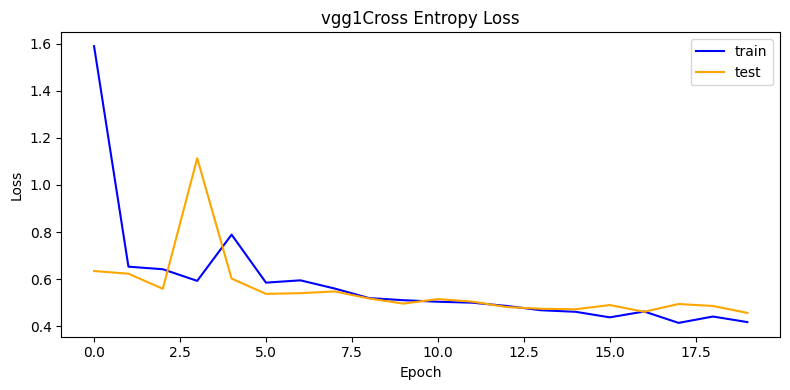

<Figure size 640x480 with 0 Axes>

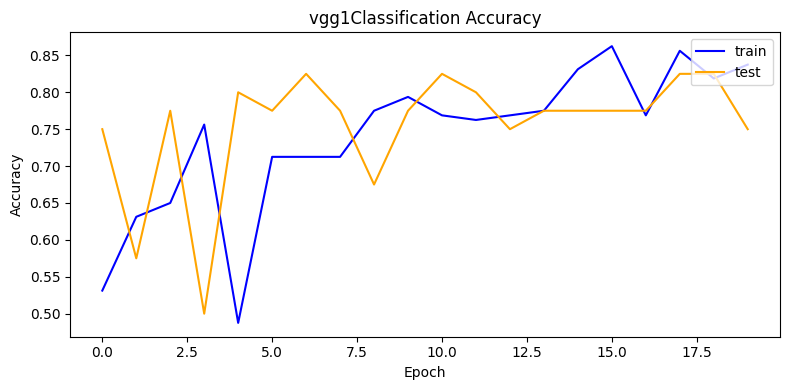

<Figure size 640x480 with 0 Axes>

In [21]:
start_time = time.time()
accuracy_vgg1 = test(vgg1,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
summarize_diagnostics(history_vgg1,'vgg1')
time_vgg1_test = end_time - start_time

In [95]:
data['Model'].append('VGG1')
data['Total Parameters'].append(params_vgg1)
data['Training Time'].append(time_vgg1)
data['Test Time'].append(time_vgg1_test)
data['Training Loss'].append(training_loss_vgg1)
data['Test Loss'].append(test_loss_vgg1)
data['Training Accuracy'].append(training_accuracy_vgg1)
data['Test Accuracy'].append(accuracy_vgg1)
pprint(data)

{'Model': ['VGG1'],
 'Test Accuracy': [75.0],
 'Test Loss': [0.45678386092185974],
 'Test Time': [1.3831956386566162],
 'Total Parameters': [40961153],
 'Training Accuracy': [0.8374999761581421],
 'Training Loss': [0.4176484942436218],
 'Training Time': [256.35839200019836]}


#### *VGG2*

In [23]:
vgg2 = VGG2()
params_vgg2 = parameters(vgg2)
print(f"Total Parameters in VGG2: {params_vgg2}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 160000)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [24]:
start_time = time.time()
history_vgg2 = train(vgg2,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test', 'vgg2')
end_time = time.time()
time_vgg2 = end_time - start_time
print(f'Time taken for VGG2: {time_vgg2}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/20
4/4 - 8s - loss: 3.0931 - accuracy: 0.4563 - val_loss: 0.7011 - val_accuracy: 0.5000 - 8s/epoch - 2s/step
Epoch 2/20
4/4 - 5s - loss: 0.6890 - accuracy: 0.6313 - val_loss: 0.6806 - val_accuracy: 0.5250 - 5s/epoch - 1s/step
Epoch 3/20
4/4 - 7s - loss: 0.6786 - accuracy: 0.5813 - val_loss: 0.6701 - val_accuracy: 0.7500 - 7s/epoch - 2s/step
Epoch 4/20
4/4 - 5s - loss: 0.6633 - accuracy: 0.6812 - val_loss: 0.6458 - val_accuracy: 0.8000 - 5s/epoch - 1s/step
Epoch 5/20
4/4 - 7s - loss: 0.6394 - accuracy: 0.6687 - val_loss: 0.6167 - val_accuracy: 0.6500 - 7s/epoch - 2s/step
Epoch 6/20
4/4 - 5s - loss: 0.6540 - accuracy: 0.5813 - val_loss: 0.6334 - val_accuracy: 0.6000 - 5s/epoch - 1s/step
Epoch 7/20
4/4 - 6s - loss: 0.6113 - accuracy: 0.6687 - val_loss: 0.6227 - val_accuracy: 0.6250 - 6s/epoch - 1s/step
Epoch 8/20
4/4 - 5s - loss: 0.6152 - accuracy: 0.6500 - val_loss: 0.5840 - val_accuracy: 0.7250 - 5s

In [25]:
training_loss_vgg2, training_accuracy_vgg2,test_loss_vgg2 = history_vgg2.history['loss'][-1], history_vgg2.history['accuracy'][-1], history_vgg2.history['val_loss'][-1]

In [26]:
training_loss_vgg2, training_accuracy_vgg2

(0.3886275887489319, 0.824999988079071)

Found 40 images belonging to 2 classes.
4/4 - 1s - loss: 0.4121 - accuracy: 0.8500 - 1s/epoch - 262ms/step
Accuracy: 85.00000238418579


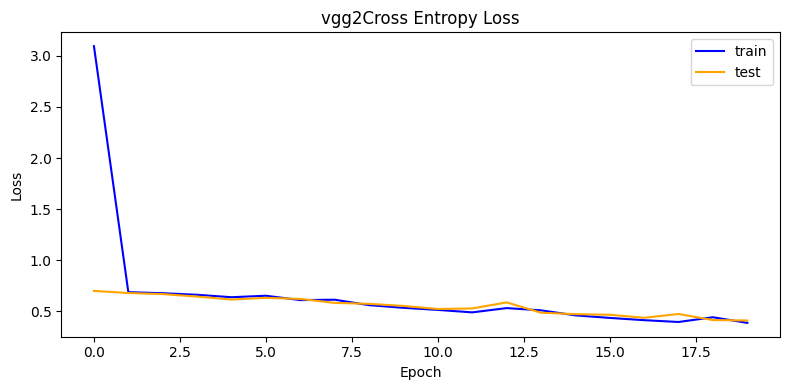

<Figure size 640x480 with 0 Axes>

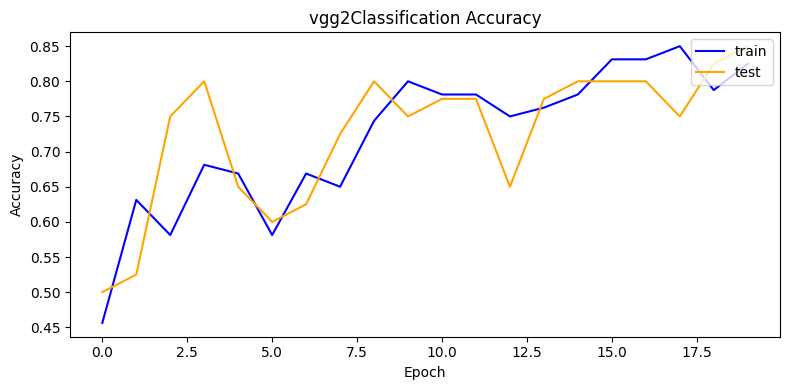

<Figure size 640x480 with 0 Axes>

In [27]:
start_time = time.time()
accuracy_vgg2 = test(vgg2,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
summarize_diagnostics(history_vgg2,'vgg2')
time_vgg2_test = end_time - start_time

In [96]:
data['Model'].append('VGG2')
data['Total Parameters'].append(params_vgg2)
data['Training Time'].append(time_vgg2)
data['Test Time'].append(time_vgg2_test)
data['Training Loss'].append(training_loss_vgg2)
data['Test Loss'].append(test_loss_vgg2)
data['Training Accuracy'].append(training_accuracy_vgg2)
data['Test Accuracy'].append(accuracy_vgg2)
pprint(data)

{'Model': ['VGG1', 'VGG2'],
 'Test Accuracy': [75.0, 85.00000238418579],
 'Test Loss': [0.45678386092185974, 0.4121007025241852],
 'Test Time': [1.3831956386566162, 1.3581860065460205],
 'Total Parameters': [40961153, 20499649],
 'Training Accuracy': [0.8374999761581421, 0.824999988079071],
 'Training Loss': [0.4176484942436218, 0.3886275887489319],
 'Training Time': [256.35839200019836, 161.68593668937683]}


#### *VGG3*

In [29]:
vgg3 = VGG3()
params_vgg3 = parameters(vgg3)
print(f"Total Parameters in VGG3: {params_vgg3}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 50, 50, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 25, 25, 128)      

In [30]:
start_time = time.time()
history_vgg3 = train(vgg3,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test', 'vgg3')
end_time = time.time()
time_vgg3 = end_time - start_time
print(f'Time taken for VGG3: {time_vgg3}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/20
4/4 - 7s - loss: 3.6659 - accuracy: 0.5000 - val_loss: 0.7542 - val_accuracy: 0.5000 - 7s/epoch - 2s/step
Epoch 2/20
4/4 - 6s - loss: 0.7239 - accuracy: 0.5063 - val_loss: 0.6794 - val_accuracy: 0.7500 - 6s/epoch - 2s/step
Epoch 3/20
4/4 - 5s - loss: 0.6904 - accuracy: 0.5688 - val_loss: 0.6861 - val_accuracy: 0.5000 - 5s/epoch - 1s/step
Epoch 4/20
4/4 - 6s - loss: 0.6996 - accuracy: 0.4688 - val_loss: 0.6708 - val_accuracy: 0.7250 - 6s/epoch - 2s/step
Epoch 5/20
4/4 - 5s - loss: 0.6683 - accuracy: 0.5562 - val_loss: 0.6543 - val_accuracy: 0.5750 - 5s/epoch - 1s/step
Epoch 6/20
4/4 - 6s - loss: 0.6241 - accuracy: 0.7312 - val_loss: 0.6258 - val_accuracy: 0.7250 - 6s/epoch - 1s/step
Epoch 7/20
4/4 - 6s - loss: 0.5709 - accuracy: 0.7875 - val_loss: 0.6088 - val_accuracy: 0.6000 - 6s/epoch - 2s/step
Epoch 8/20
4/4 - 5s - loss: 0.5857 - accuracy: 0.6625 - val_loss: 0.6602 - val_accuracy: 0.5500 - 5s

In [31]:
training_loss_vgg3, training_accuracy_vgg3,test_loss_vgg3 = history_vgg3.history['loss'][-1], history_vgg3.history['accuracy'][-1], history_vgg3.history['val_loss'][-1]

In [32]:
training_loss_vgg3, training_accuracy_vgg3

(0.2137933075428009, 0.949999988079071)

Found 40 images belonging to 2 classes.
4/4 - 1s - loss: 0.4678 - accuracy: 0.8000 - 986ms/epoch - 246ms/step
Accuracy: 80.0000011920929


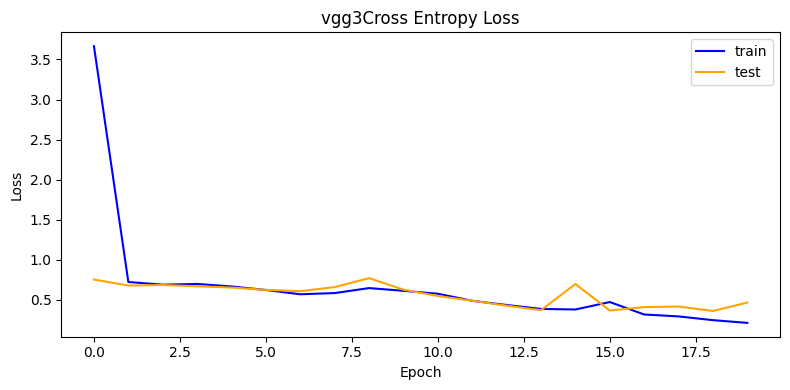

<Figure size 640x480 with 0 Axes>

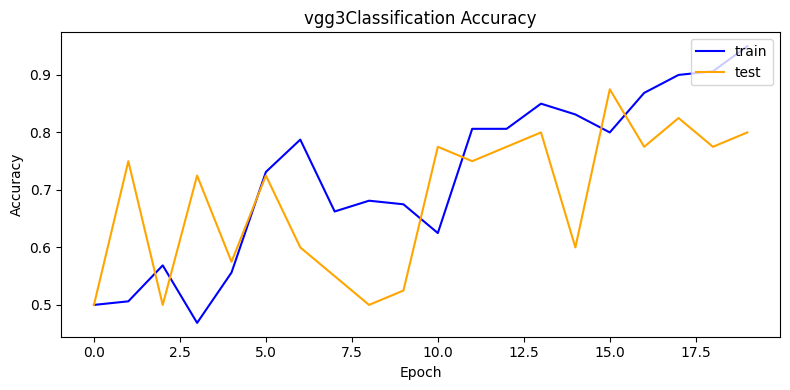

<Figure size 640x480 with 0 Axes>

In [33]:
start_time = time.time()
accuracy_vgg3 = test(vgg3,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
summarize_diagnostics(history_vgg3,'vgg3')
time_vgg3_test = end_time - start_time

In [97]:
data['Model'].append('VGG3')
data['Total Parameters'].append(params_vgg3)
data['Training Time'].append(time_vgg3)
data['Test Time'].append(time_vgg3_test)
data['Training Loss'].append(training_loss_vgg3)
data['Test Loss'].append(test_loss_vgg3)
data['Training Accuracy'].append(training_accuracy_vgg3)
data['Test Accuracy'].append(accuracy_vgg3)
pprint(data)

{'Model': ['VGG1', 'VGG2', 'VGG3'],
 'Test Accuracy': [75.0, 85.00000238418579, 80.0000011920929],
 'Test Loss': [0.45678386092185974, 0.4121007025241852, 0.4677637219429016],
 'Test Time': [1.3831956386566162, 1.3581860065460205, 1.2247648239135742],
 'Total Parameters': [40961153, 20499649, 10333505],
 'Training Accuracy': [0.8374999761581421,
                       0.824999988079071,
                       0.949999988079071],
 'Training Loss': [0.4176484942436218, 0.3886275887489319, 0.2137933075428009],
 'Training Time': [256.35839200019836, 161.68593668937683, 150.28819823265076]}


#### *VGG3 (with augmentation)*

In [35]:
vgg3_aug = VGG3()
params_vgg3_aug = parameters(vgg3_aug)
print(f"Total Parameters in VGG3 augmented data: {params_vgg3_aug}")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 50, 50, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 25, 25, 128)      

In [36]:
start_time = time.time()
history_vgg3_aug = train_augmentation(vgg3_aug,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test','vgg3_aug')
end_time = time.time()
time_vgg3_aug = end_time - start_time
print(f'Time taken for VGG3 with augmentation: {time_vgg3_aug}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/20
4/4 - 9s - loss: 9.7488 - accuracy: 0.5500 - val_loss: 0.7038 - val_accuracy: 0.5000 - 9s/epoch - 2s/step
Epoch 2/20
4/4 - 7s - loss: 0.7122 - accuracy: 0.5063 - val_loss: 0.7187 - val_accuracy: 0.5000 - 7s/epoch - 2s/step
Epoch 3/20
4/4 - 8s - loss: 0.6591 - accuracy: 0.5813 - val_loss: 0.6074 - val_accuracy: 0.7500 - 8s/epoch - 2s/step
Epoch 4/20
4/4 - 7s - loss: 0.6235 - accuracy: 0.6687 - val_loss: 0.6061 - val_accuracy: 0.6500 - 7s/epoch - 2s/step
Epoch 5/20
4/4 - 8s - loss: 0.6199 - accuracy: 0.6375 - val_loss: 0.5236 - val_accuracy: 0.7000 - 8s/epoch - 2s/step
Epoch 6/20
4/4 - 8s - loss: 0.5855 - accuracy: 0.6812 - val_loss: 0.5841 - val_accuracy: 0.7250 - 8s/epoch - 2s/step
Epoch 7/20
4/4 - 7s - loss: 0.5643 - accuracy: 0.7312 - val_loss: 0.6082 - val_accuracy: 0.6500 - 7s/epoch - 2s/step
Epoch 8/20
4/4 - 8s - loss: 0.6549 - accuracy: 0.5875 - val_loss: 0.5576 - val_accuracy: 0.7500 - 8s

In [37]:
training_loss_vgg3_aug, training_accuracy_vgg3_aug,test_loss_vgg3_aug = history_vgg3_aug.history['loss'][-1], history_vgg3_aug.history['accuracy'][-1], history_vgg3_aug.history['val_loss'][-1]

In [38]:
training_loss_vgg3_aug, training_accuracy_vgg3_aug

(0.4152609705924988, 0.856249988079071)

Found 40 images belonging to 2 classes.
4/4 - 1s - loss: 0.3697 - accuracy: 0.8750 - 999ms/epoch - 250ms/step
Accuracy: 87.5


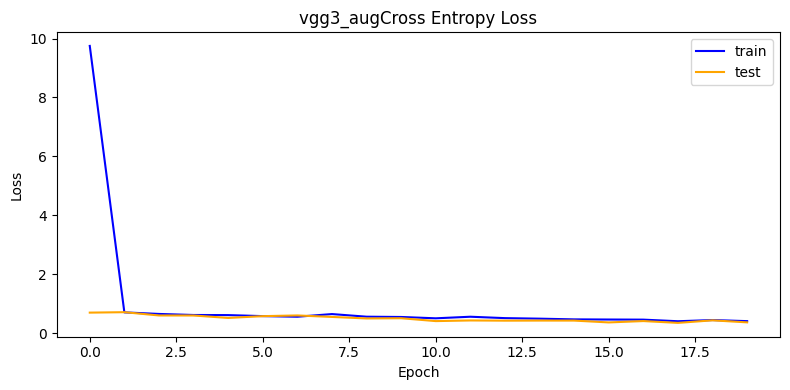

<Figure size 640x480 with 0 Axes>

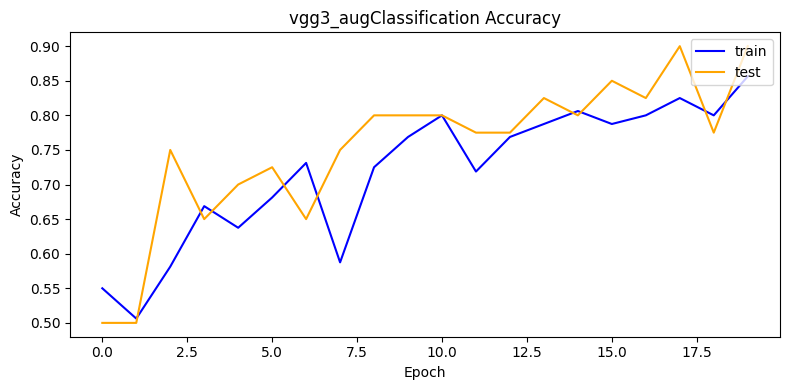

<Figure size 640x480 with 0 Axes>

In [39]:
start_time = time.time()
accuracy_vgg3_aug = test(vgg3_aug,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
summarize_diagnostics(history_vgg3_aug,'vgg3_aug')
time_vgg3_aug_test = end_time - start_time

In [98]:
data['Model'].append('VGG3 with Augmentation')
data['Total Parameters'].append(params_vgg3_aug)
data['Training Time'].append(time_vgg3_aug)
data['Test Time'].append(time_vgg3_aug_test)
data['Training Loss'].append(training_loss_vgg3_aug)
data['Test Loss'].append(test_loss_vgg3_aug)
data['Training Accuracy'].append(training_accuracy_vgg3_aug)
data['Test Accuracy'].append(accuracy_vgg3_aug)
pprint(data)

{'Model': ['VGG1', 'VGG2', 'VGG3', 'VGG3 with Augmentation'],
 'Test Accuracy': [75.0, 85.00000238418579, 80.0000011920929, 87.5],
 'Test Loss': [0.45678386092185974,
               0.4121007025241852,
               0.4677637219429016,
               0.37368136644363403],
 'Test Time': [1.3831956386566162,
               1.3581860065460205,
               1.2247648239135742,
               1.2836108207702637],
 'Total Parameters': [40961153, 20499649, 10333505, 10333505],
 'Training Accuracy': [0.8374999761581421,
                       0.824999988079071,
                       0.949999988079071,
                       0.856249988079071],
 'Training Loss': [0.4176484942436218,
                   0.3886275887489319,
                   0.2137933075428009,
                   0.4152609705924988],
 'Training Time': [256.35839200019836,
                   161.68593668937683,
                   150.28819823265076,
                   173.53712844848633]}


#### *VGG16 (with tunning all the layers)*

In [72]:
vgg16_all = vgg16()
params_vgg16_all = parameters(vgg16_all)
print(f"Total Parameters in VGG16: {params_vgg16_all}")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

In [73]:
start_time = time.time()
history_vgg16 = train(vgg16_all,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test', 'vgg16_all')
end_time = time.time()
time_vgg16_all = end_time - start_time
print(f'Time taken for VGG16: {time_vgg16_all}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/20
4/4 - 9s - loss: 0.7394 - accuracy: 0.5250 - val_loss: 1.2105 - val_accuracy: 0.5000 - 9s/epoch - 2s/step
Epoch 2/20
4/4 - 6s - loss: 0.7117 - accuracy: 0.6000 - val_loss: 0.5453 - val_accuracy: 0.6500 - 6s/epoch - 2s/step
Epoch 3/20
4/4 - 6s - loss: 0.2939 - accuracy: 0.9000 - val_loss: 0.3620 - val_accuracy: 0.8000 - 6s/epoch - 2s/step
Epoch 4/20
4/4 - 6s - loss: 0.4143 - accuracy: 0.8250 - val_loss: 0.2225 - val_accuracy: 0.8750 - 6s/epoch - 2s/step
Epoch 5/20
4/4 - 7s - loss: 0.2688 - accuracy: 0.8750 - val_loss: 0.3985 - val_accuracy: 0.9000 - 7s/epoch - 2s/step
Epoch 6/20
4/4 - 7s - loss: 0.2982 - accuracy: 0.8687 - val_loss: 0.2826 - val_accuracy: 0.8750 - 7s/epoch - 2s/step
Epoch 7/20
4/4 - 6s - loss: 0.1717 - accuracy: 0.9312 - val_loss: 0.1856 - val_accuracy: 0.9000 - 6s/epoch - 2s/step
Epoch 8/20
4/4 - 7s - loss: 0.0304 - accuracy: 0.9937 - val_loss: 0.1285 - val_accuracy: 0.9250 - 7s

In [74]:
training_loss_vgg16_all, training_accuracy_vgg16_all,test_loss_vgg16_all = history_vgg16.history['loss'][-1], history_vgg16.history['accuracy'][-1], history_vgg16.history['val_loss'][-1]

In [75]:
training_loss_vgg16_all, training_accuracy_vgg16_all

(0.0014885234413668513, 1.0)

Found 40 images belonging to 2 classes.
4/4 - 1s - loss: 0.3457 - accuracy: 0.9250 - 1s/epoch - 275ms/step
Accuracy: 92.5000011920929


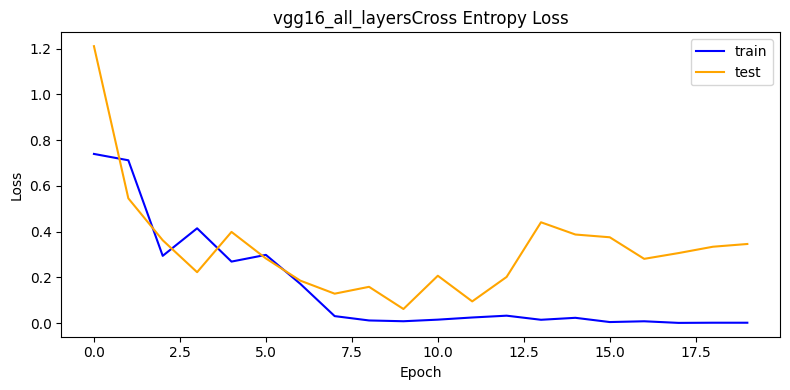

<Figure size 640x480 with 0 Axes>

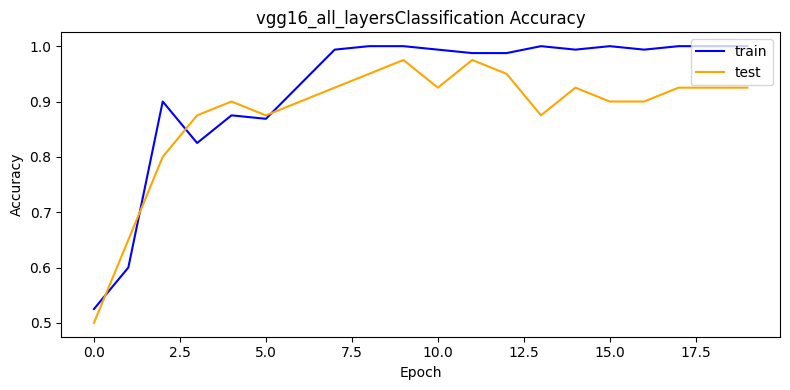

<Figure size 640x480 with 0 Axes>

In [76]:
start_time = time.time()
accuracy_vgg16_all = test(vgg16_all,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
summarize_diagnostics(history_vgg16,'vgg16_all_layers')
time_vgg16_all_test = end_time - start_time

In [99]:
data['Model'].append('VGG16 (All Layers)')
data['Total Parameters'].append(params_vgg16_all)
data['Training Time'].append(time_vgg16_all)
data['Test Time'].append(time_vgg16_all_test)
data['Training Loss'].append(training_loss_vgg16_all)
data['Test Loss'].append(test_loss_vgg16_all)
data['Training Accuracy'].append(training_accuracy_vgg16_all)
data['Test Accuracy'].append(accuracy_vgg16_all)
pprint(data)

{'Model': ['VGG1',
           'VGG2',
           'VGG3',
           'VGG3 with Augmentation',
           'VGG16 (All Layers)'],
 'Test Accuracy': [75.0,
                   85.00000238418579,
                   80.0000011920929,
                   87.5,
                   92.5000011920929],
 'Test Loss': [0.45678386092185974,
               0.4121007025241852,
               0.4677637219429016,
               0.37368136644363403,
               0.3457207679748535],
 'Test Time': [1.3831956386566162,
               1.3581860065460205,
               1.2247648239135742,
               1.2836108207702637,
               1.6012859344482422],
 'Total Parameters': [40961153, 20499649, 10333505, 10333505, 17074241],
 'Training Accuracy': [0.8374999761581421,
                       0.824999988079071,
                       0.949999988079071,
                       0.856249988079071,
                       1.0],
 'Training Loss': [0.4176484942436218,
                   0.3886275887489319,
      

#### *VGG16 (with tunning only mlp layer)*

In [77]:
vgg16_mlp = vgg16_MLP()
params_vgg16_mlp = parameters(vgg16_mlp)
print(f"Total Parameters in VGG16 with MLP: {params_vgg16_mlp}")

# Tunable parameters
vgg16_mlp_trainable = 0
for layers in vgg16_mlp.layers[-2:]:
    vgg16_mlp_trainable += layers.count_params()
print(f"Parameters in VGG16 with MLP which are trainable: {vgg16_mlp_trainable}")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

In [78]:
start_time = time.time()
history_vgg16_mlp = train(vgg16_mlp,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test','vgg16_mlp')
end_time = time.time()
time_vgg16_mlp = end_time - start_time
print(f'Time taken for VGG16 with MLP: {time_vgg16_mlp}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/20
4/4 - 8s - loss: 0.8736 - accuracy: 0.4875 - val_loss: 0.6914 - val_accuracy: 0.5000 - 8s/epoch - 2s/step
Epoch 2/20
4/4 - 7s - loss: 0.6694 - accuracy: 0.6125 - val_loss: 0.6135 - val_accuracy: 0.9500 - 7s/epoch - 2s/step
Epoch 3/20
4/4 - 6s - loss: 0.5986 - accuracy: 0.8188 - val_loss: 0.5485 - val_accuracy: 0.9500 - 6s/epoch - 1s/step
Epoch 4/20
4/4 - 6s - loss: 0.4927 - accuracy: 0.9438 - val_loss: 0.4565 - val_accuracy: 0.9250 - 6s/epoch - 2s/step
Epoch 5/20
4/4 - 6s - loss: 0.4325 - accuracy: 0.8188 - val_loss: 0.3481 - val_accuracy: 0.9500 - 6s/epoch - 1s/step
Epoch 6/20
4/4 - 6s - loss: 0.3105 - accuracy: 0.9375 - val_loss: 0.3478 - val_accuracy: 0.8500 - 6s/epoch - 2s/step
Epoch 7/20
4/4 - 5s - loss: 0.2333 - accuracy: 0.9187 - val_loss: 0.2196 - val_accuracy: 0.9250 - 5s/epoch - 1s/step
Epoch 8/20
4/4 - 7s - loss: 0.1451 - accuracy: 0.9625 - val_loss: 0.1838 - val_accuracy: 0.9500 - 7s

In [79]:
training_loss_vgg16_mlp, training_accuracy_vgg16_mlp,test_loss_vgg16_mlp = history_vgg16_mlp.history['loss'][-1], history_vgg16_mlp.history['accuracy'][-1], history_vgg16_mlp.history['val_loss'][-1]

In [80]:
training_loss_vgg16_mlp, training_accuracy_vgg16_mlp

(0.012941332533955574, 1.0)

Found 40 images belonging to 2 classes.
4/4 - 1s - loss: 0.1273 - accuracy: 0.9500 - 1s/epoch - 283ms/step
Accuracy: 94.9999988079071


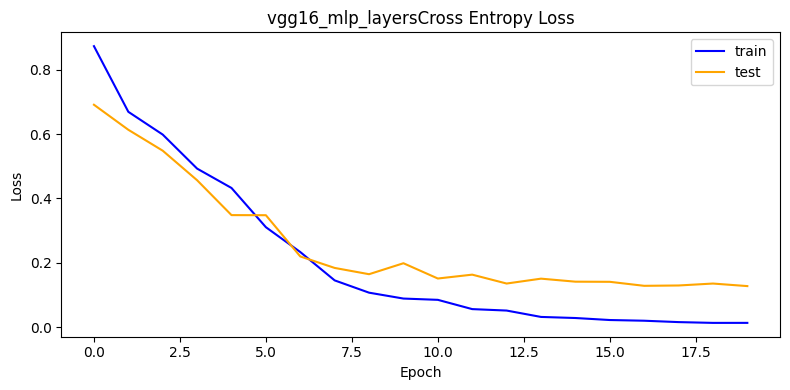

<Figure size 640x480 with 0 Axes>

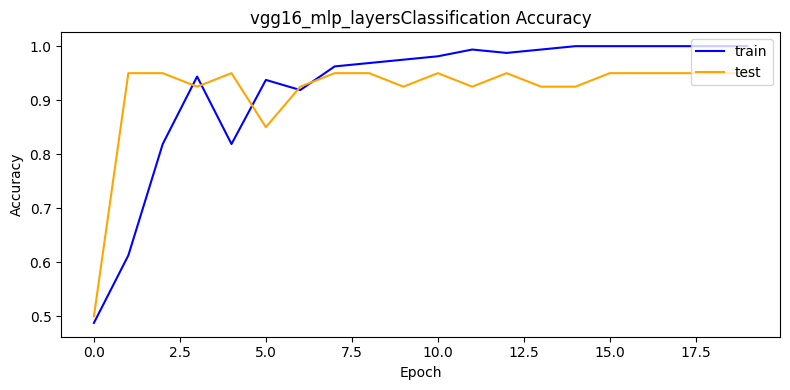

<Figure size 640x480 with 0 Axes>

In [81]:
start_time = time.time()
accuracy_vgg16_mlp = test(vgg16_mlp,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
summarize_diagnostics(history_vgg16_mlp,'vgg16_mlp_layers')
time_vgg16_mlp_test = end_time - start_time

In [100]:
data['Model'].append('VGG16 with tuning MLP')
data['Total Parameters'].append(vgg16_mlp_trainable)
data['Training Time'].append(time_vgg16_mlp)
data['Test Time'].append(time_vgg16_mlp_test)
data['Training Loss'].append(training_loss_vgg16_mlp)
data['Test Loss'].append(test_loss_vgg16_mlp)
data['Training Accuracy'].append(training_accuracy_vgg16_mlp)
data['Test Accuracy'].append(accuracy_vgg16_mlp)
pprint(data)

{'Model': ['VGG1',
           'VGG2',
           'VGG3',
           'VGG3 with Augmentation',
           'VGG16 (All Layers)',
           'VGG16 with tuning MLP'],
 'Test Accuracy': [75.0,
                   85.00000238418579,
                   80.0000011920929,
                   87.5,
                   92.5000011920929,
                   94.9999988079071],
 'Test Loss': [0.45678386092185974,
               0.4121007025241852,
               0.4677637219429016,
               0.37368136644363403,
               0.3457207679748535,
               0.1273323893547058],
 'Test Time': [1.3831956386566162,
               1.3581860065460205,
               1.2247648239135742,
               1.2836108207702637,
               1.6012859344482422,
               1.601738452911377],
 'Total Parameters': [40961153,
                      20499649,
                      10333505,
                      10333505,
                      17074241,
                      2359553],
 'Training Accuracy':

#### *MLP Model (Having comparable parameters to VGG16 model)*

In [92]:
mlp = MLP()
params_mlp = parameters(mlp)
print(f"Total Parameters in MLP model: {params_mlp}")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 120000)            0         
                                                                 
 dense_28 (Dense)            (None, 128)               15360128  
                                                                 
 dense_29 (Dense)            (None, 1)                 129       
                                                                 
Total params: 15360257 (58.59 MB)
Trainable params: 15360257 (58.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Total Parameters in MLP model: 15360257


In [93]:
start_time = time.time()
history_mlp = train(mlp,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/train', '/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test','mlp')
end_time = time.time()
time_mlp = end_time - start_time
print(f'Time taken for MLP: {time_mlp}')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/20
4/4 - 7s - loss: 0.8577 - accuracy: 0.5188 - val_loss: 1.0808 - val_accuracy: 0.5000 - 7s/epoch - 2s/step
Epoch 2/20
4/4 - 5s - loss: 0.7264 - accuracy: 0.6438 - val_loss: 0.7070 - val_accuracy: 0.5000 - 5s/epoch - 1s/step
Epoch 3/20
4/4 - 6s - loss: 0.6543 - accuracy: 0.6000 - val_loss: 0.6133 - val_accuracy: 0.6500 - 6s/epoch - 2s/step
Epoch 4/20
4/4 - 5s - loss: 0.5832 - accuracy: 0.7188 - val_loss: 0.4993 - val_accuracy: 0.7500 - 5s/epoch - 1s/step
Epoch 5/20
4/4 - 6s - loss: 0.5087 - accuracy: 0.8062 - val_loss: 0.4611 - val_accuracy: 0.7500 - 6s/epoch - 2s/step
Epoch 6/20
4/4 - 5s - loss: 0.4938 - accuracy: 0.7500 - val_loss: 0.4415 - val_accuracy: 0.7750 - 5s/epoch - 1s/step
Epoch 7/20
4/4 - 6s - loss: 0.4386 - accuracy: 0.8438 - val_loss: 0.4423 - val_accuracy: 0.7500 - 6s/epoch - 2s/step
Epoch 8/20
4/4 - 5s - loss: 0.4227 - accuracy: 0.8125 - val_loss: 0.4514 - val_accuracy: 0.8000 - 5s

Found 40 images belonging to 2 classes.
4/4 - 1s - loss: 0.5190 - accuracy: 0.8000 - 996ms/epoch - 249ms/step
Accuracy: 80.0000011920929


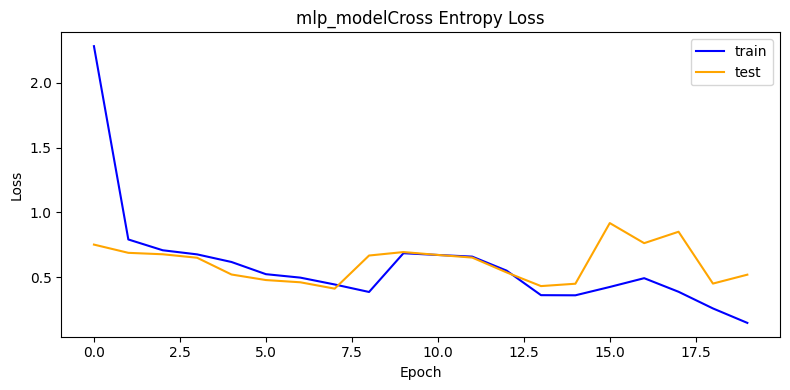

<Figure size 640x480 with 0 Axes>

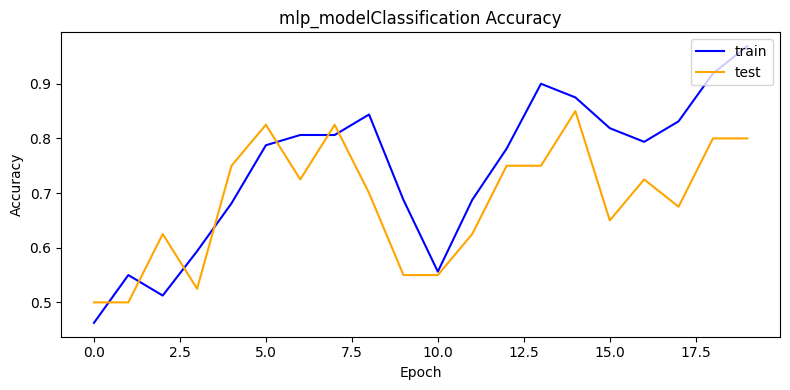

<Figure size 640x480 with 0 Axes>

In [90]:
start_time = time.time()
accuracy_mlp = test(mlp,'/content/drive/MyDrive/ES335-Assignment-4-matrix-minds/Question-1/dataset_koala_vs_bear/test')
end_time = time.time()
time_mlp_test = end_time - start_time
summarize_diagnostics(history_mlp,'mlp_model')

In [56]:
training_loss_mlp, training_accuracy_mlp,test_loss_mlp = history_mlp.history['loss'][-1], history_mlp.history['accuracy'][-1], history_mlp.history['val_loss'][-1]

In [101]:
data['Model'].append('MLP')
data['Total Parameters'].append(params_mlp)
data['Training Time'].append(time_mlp)
data['Test Time'].append(time_mlp_test)
data['Training Loss'].append(training_loss_mlp)
data['Test Loss'].append(test_loss_mlp)
data['Training Accuracy'].append(training_accuracy_mlp)
data['Test Accuracy'].append(accuracy_mlp)
pprint(data)

{'Model': ['VGG1',
           'VGG2',
           'VGG3',
           'VGG3 with Augmentation',
           'VGG16 (All Layers)',
           'VGG16 with tuning MLP',
           'MLP'],
 'Test Accuracy': [75.0,
                   85.00000238418579,
                   80.0000011920929,
                   87.5,
                   92.5000011920929,
                   94.9999988079071,
                   80.0000011920929],
 'Test Loss': [0.45678386092185974,
               0.4121007025241852,
               0.4677637219429016,
               0.37368136644363403,
               0.3457207679748535,
               0.1273323893547058,
               0.41158246994018555],
 'Test Time': [1.3831956386566162,
               1.3581860065460205,
               1.2247648239135742,
               1.2836108207702637,
               1.6012859344482422,
               1.601738452911377,
               1.5475881099700928],
 'Total Parameters': [40961153,
                      20499649,
                      1

#### *Data Frame*

In [102]:
df = pd.DataFrame(data)
df.to_csv('results.csv', index=False)
df

,Model,Total Parameters,Training Time,Test Time,Training Loss,Test Loss,Training Accuracy,Test Accuracy
0,VGG1,40961153,256.358392,1.383196,0.417648,0.456784,0.83750,75.000000
1,VGG2,20499649,161.685937,1.358186,0.388628,0.412101,0.82500,85.000002
2,VGG3,10333505,150.288198,1.224765,0.213793,0.467764,0.95000,80.000001
3,VGG3 with Augmentation,10333505,173.537128,1.283611,0.415261,0.373681,0.85625,87.500000
4,VGG16 (All Layers),17074241,163.357261,1.601286,0.001489,0.345721,1.00000,92.500001
5,VGG16 with tuning MLP,2359553,146.492226,1.601738,0.012941,0.127332,1.00000,94.999999
6,MLP,15360257,156.193763,1.547588,0.176693,0.411582,0.97500,80.000001


### Subjective Questions

##### *Question 1: Are the results as expected? Why or why not?*

- The outcomes align with our expectations: VGG models with 1 and 3 blocks exhibit accuracies of 75% and 80% respectively. However, when data augmentation is applied to the VGG3 block model, its accuracy surpasses that of the standard VGG3 without such augmentation, reaching 87.5%. This improvement is attributed to the data augmentation technique, which artificially generates more data to enhance the model's learning capability.

- Transitioning to the VGG16 model, when all layers are trainable, it achieves an impressive accuracy of 92.5%. In contrast, the VGG16 model with only the final MLP layers trainable performs even better, achieving an accuracy of 95%. This discrepancy can be attributed to transfer learning: the latter model utilizes pre-trained weights from the ImageNet dataset, resulting in a more robust feature extractor compared to our dataset.

- Moreover, the model comprising only MLP layers, with parameters comparable to those of the VGG16 model, achieves an accuracy of 80%. This difference arises due to the inherent dissimilarities in how convolutional layers and MLP layers handle spatial information. While the convolutional layers in VGG16 act as local feature extractors, providing translational invariance to the model, MLP layers lack this property. Consequently, even minor shifts in the image can significantly impact the performance of the MLP model, whereas VGG16 remains more resilient to such variations.

##### *Question 2: Does data augmentation help? Why or why not?*

- Yes, data augmentation does help. When data augmentation was applied to the VGG3 block model, its accuracy improved from 80% to 87.5%. This improvement underscores the effectiveness of data augmentation in enhancing model performance. Data augmentation is beneficial because it artificially creates more training data by applying random transformations to existing examples. This process diversifies the training dataset, enabling the model to learn more robust features and reducing overfitting. Consequently, the model becomes better equipped to generalize to unseen data, resulting in improved accuracy on the test set.

##### *Question 3: Does it matter how many epochs you fine tune the model? Why or why not?*

- Yes, the number of epochs does matter when fine-tuning a model. Each epoch allows the model to learn features from the images, potentially leading to improved classification accuracy. However, training for too many epochs can result in overfitting, where the model memorizes the training data and fails to generalize well to new data. Therefore, it's essential to strike a balance and choose an appropriate number of epochs to ensure the model effectively learns image features while also generalizing well.

##### *Question 4: Are there any particular images that the model is confused about? Why or why not?*

- Yes, there are particular images that the model is confused about. This confusion arises when the features of the image are not clear, making it difficult even for humans to determine the correct class. For example, there is an image of a bear where all models except VGG16, trained only with MLP layers, predict it to be a Koala. Similarly, another image depicting a distant and blurry bear also leads to confusion among all models, which incorrectly classify it as a Koala. These instances highlight the challenges faced by the model when encountering ambiguous or unclear images.